In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    colab_loc='/content/drive/My Drive/Colab Notebooks/RT-predict/'
    loc=colab_loc
except:
    loc=''
    from  infrastructure import profiler_parse
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm
columns=['benchmark','input','pid','function','call occurrence','runtime (sec)','cache misses','cache references','retired instructions','branch misses','page faults']

In [2]:
try: 
    f=open(loc+'data/cleaned_data_no_header.pkl','rb')
    data_mat = pickle.load(f)
except: 
    data_mat,columns=profiler_parse.read_datafile('data/10_runs_5_inputs_5_bmarks_raw.csv')

loading raw data
loaded raw data
processing raw data


  0%|          | 0/5110786 [00:00<?, ?it/s]

In [3]:
data=pd.DataFrame(data_mat,columns=columns)
for column in ['pid','call occurrence','cache misses','cache references','retired instructions','branch misses','page faults']:
    data[column] = data[column].astype("int64")
for column in ['benchmark','input','function']:
    data[column] = data[column].astype("string")
data['runtime (sec)'] = data['runtime (sec)'].astype('float64') 
print(data.dtypes)
data

benchmark                string
input                    string
pid                       int64
function                 string
call occurrence           int64
runtime (sec)           float64
cache misses              int64
cache references          int64
retired instructions      int64
branch misses             int64
page faults               int64
dtype: object


,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,disparity,sim_fast,10409,0x7f1b9fda34fc,0,0.0001,6840,18333,181296,2947,87
1,disparity,sim_fast,10409,readImage,0,0.0001,976,2733,8212,231,5
2,disparity,sim_fast,10409,readImage,0,0.0074,240,293,2162,21,0
3,disparity,sim_fast,10409,readImage,0,0.0001,876,1855,954512,139,3
4,disparity,sim_fast,10409,readImage,0,0.0001,470,1491,448033,106,0
...,...,...,...,...,...,...,...,...,...,...,...
451645,sift,vga,19549,periodic_benchmark,0,0.9111,33,58,12,2,0
451646,sift,vga,19549,get_rdtsc,0,0.0001,58,133,21,6,0
451647,sift,vga,19549,0x7f0ac654f560,1,0.0001,2115,3848,28952,453,1
451648,sift,vga,19549,iFreeHandle,5,0.0001,260,687,1048,42,0


In [4]:
# compute application and function performance profiles
app_profiles=data.groupby(['benchmark','input','pid'])[['runtime (sec)','cache misses' ,'cache references' ,'retired instructions','branch misses','page faults']].sum().reset_index()
functions=data.groupby(['benchmark','input','pid','function','call occurrence']).sum().reset_index()
columns_to_norm=['cache misses' ,'cache references' ,'retired instructions','branch misses','page faults']
#normalize functions profiles
normed_functions=functions.copy()
for column in tqdm(columns_to_norm):
        normed_functions[column]=normed_functions[column]/normed_functions['runtime (sec)']

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
normed_functions.head()

,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,disparity,cif,11476,0x7f9a5109bbb1,0,0.0017,3.714118e+06,9.071765e+06,9.735118e+07,1.506471e+06,48235.294118
1,disparity,cif,11476,__wrap_malloc,0,0.0002,3.335000e+06,4.395000e+06,4.715000e+06,2.500000e+05,5000.000000
2,disparity,cif,11476,__wrap_malloc,1,0.0001,2.440000e+06,3.980000e+06,3.230000e+06,2.300000e+05,10000.000000
3,disparity,cif,11476,__wrap_malloc,2,0.0001,1.500000e+06,1.573000e+07,2.445040e+09,9.700000e+05,170000.000000
4,disparity,cif,11476,__wrap_malloc,3,0.0001,1.810000e+06,7.441000e+07,8.202510e+09,1.090000e+06,0.000000


In [6]:
def feature_grid_clusters(data,labels,title):
    u_labels = np.unique(labels)
    num = 0
    plt.figure(figsize=(10, 10))
    plt.title(title)
    for i in range(1, data.shape[1]):
        for j in range(1, data.shape[1]):
            num += 1
            plt.subplot(data.shape[1], data.shape[1], num)
            for k in u_labels:
                plt.scatter(data[labels == k, i],
                            data[labels == k, j], label=k)
    plt.show()


In [7]:
def plot_clusters(data,labels,title):
    plt.title(title)
    pca = PCA(2)
    read_data=pca.fit_transform(data)
    u_labels=np.unique(labels)
    for k in u_labels:
        filtered=read_data[labels==k]
        plt.scatter(filtered[0],filtered[1],label=k)

In [8]:
def evaluate_clusterings(X,clusterings=['KMeans','GMM','Agglomerative (Ward)','OPTICS'],clusters_list=range(2,25+1)):
    best_clusterings = []
    best_labels=[]
    plt.figure(figsize=(10, 10))
    cluster_num=len(clusterings)
    if cluster_num % 2 != 0:
        cluster_num+=1
    if 'KMeans' in clusterings:
        cluster_num+=1
    for i in tqdm(range(len(clusterings))):
        clustering=clusterings[i]
        print(f'Evaluating {clustering} clustering')
        scores = []
        kmeans_costs=[]
        labels=[]
        tmp_clusterings = []
        for clusters in tqdm(clusters_list):
            if clustering == 'KMeans':
                tmp_clustering = KMeans(random_state=0,n_clusters=clusters)
            elif clustering == 'GMM':
                tmp_clustering = GaussianMixture(random_state=0,n_components=clusters)
            elif clustering == 'DBSCAN':
                clusters=clusters/X.shape[1]
                tmp_clustering=DBSCAN(n_jobs=-1)
            elif clustering == 'OPTICS':
                tmp_clustering=OPTICS(n_jobs=-1,)
            elif 'Agglomerative' in clustering:
                tmp_clustering=AgglomerativeClustering(n_clusters=clusters)
            elif clustering == 'Spectral':
                tmp_clustering=SpectralClustering(random_state=0,n_clusters=clusters)
            labels.append(tmp_clustering.fit_predict(X))
            tmp_clusterings.append(tmp_clustering)
            score=silhouette_score(X, labels[-1])
            scores.append(score)
            if clustering == 'KMeans':
              kmeans_costs.append(tmp_clustering.inertia_)
        best = np.argmax(scores)
        #print(f'{clustering} scores: {scores} best id: {best}')
        print(f'best: clusters:{np.unique(labels[best]).shape[0]} score:{scores[best]}')
        best_clusterings.append(tmp_clusterings[best])
        best_labels.append(labels[best])
        if clustering != 'DBSCAN' and clustering !='OPTICS':
            plt.subplot(cluster_num//2+1,cluster_num//2+1,i+1)
            plt.title(clustering+" silouhette score")
            plt.plot(clusters_list, scores)
        if clustering == 'KMeans':
            i+=1
            plt.subplot(cluster_num//2+1,cluster_num//2+1,i+1)
            plt.title(clustering+' cost')
            plt.plot(clusters_list, kmeans_costs)
    plt.show()
    return best_clusterings,best_labels,clusterings

  0%|          | 0/5 [00:00<?, ?it/s]

Clustering on cache misses


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:2 score:0.9760289940361861


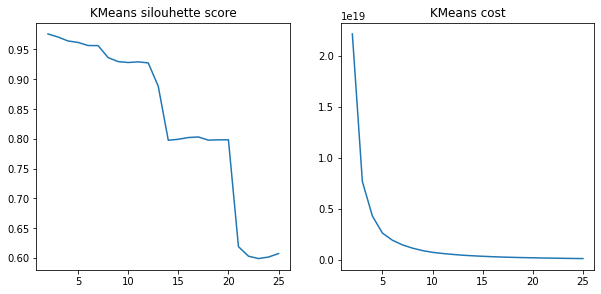

Clustering on cache references


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:2 score:0.9394581693952629


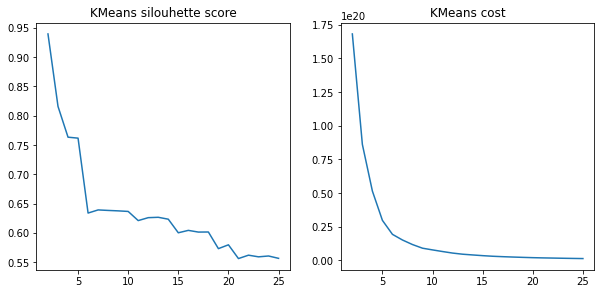

Clustering on retired instructions


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:6 score:0.6768598492345035


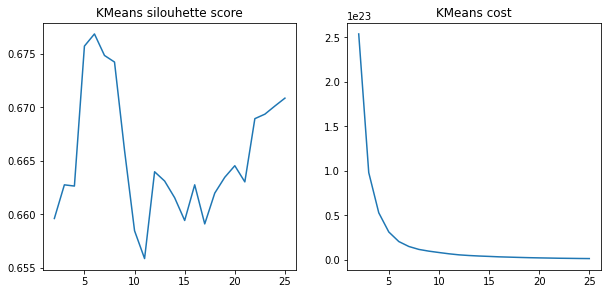

Clustering on branch misses


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:2 score:0.9704416675781344


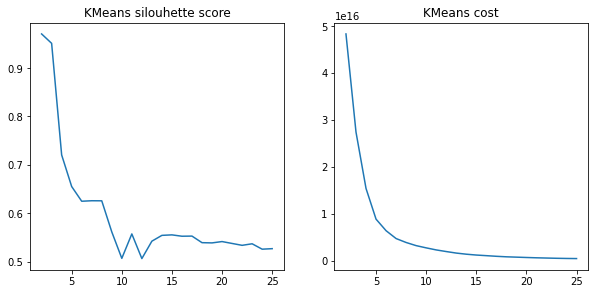

Clustering on page faults


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:2 score:0.9879708634299174


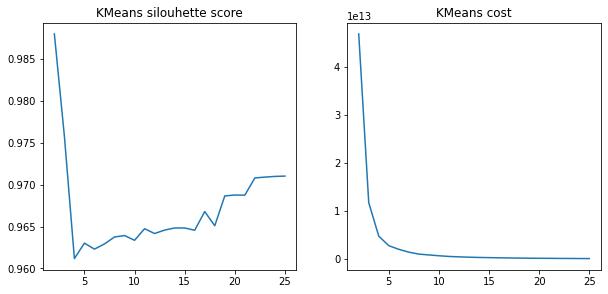

In [9]:
for column in tqdm(columns_to_norm):
    print(f"Clustering on {column}")
    best_clusterings,best_labels,clusterings_str=evaluate_clusterings(normed_functions[column].to_numpy().reshape(-1, 1),['KMeans'])

In [14]:
clustering={}
labels={}
centers={}
for column in tqdm(columns_to_norm):
    clustering[column] = KMeans(random_state=0,n_clusters=5)
    labels[column]=clustering[column].fit_predict(normed_functions[column].to_numpy().reshape(-1, 1))
    centers[column]=clustering[column].cluster_centers_.ravel()
pd.DataFrame(centers)

  0%|          | 0/5 [00:00<?, ?it/s]

,cache misses,cache references,retired instructions,branch misses,page faults
0,1.180299e+06,1.853757e+07,8.435444e+09,5.032004e+05,381.839915
1,3.283311e+08,9.164906e+08,1.824794e+08,1.452164e+07,868135.593220
2,1.912666e+08,3.164599e+08,5.225711e+09,1.331357e+06,296760.301576
3,7.932721e+07,1.022616e+08,1.185346e+10,5.072679e+06,157632.546399
4,4.047223e+08,6.408928e+08,2.694549e+09,2.762000e+07,50926.101656


In [15]:
# check for functions that might create bottlenecks
bottleneck_df=pd.DataFrame()
for column in tqdm(columns_to_norm):
    bottleneck_id=np.argmax(centers[column])
    normed_functions["bottleneck on "+column]= (labels[column] == bottleneck_id)
    normed_functions["bottleneck on "+column]
    print(f"bottleneck on {column}: {np.count_nonzero(normed_functions['bottleneck on '+column])} over {normed_functions['bottleneck on '+column].shape[0]}")

  0%|          | 0/5 [00:00<?, ?it/s]

bottleneck on cache misses: 610 over 68640
bottleneck on cache references: 563 over 68640
bottleneck on retired instructions: 5332 over 68640
bottleneck on branch misses: 198 over 68640
bottleneck on page faults: 177 over 68640


In [16]:
#check for functions that can make the application miss the deadline
#these functions are the ones that have high cache misses, page faults, branch misses and low retired instructions
cols=['bottleneck on cache misses','bottleneck on branch misses','bottleneck on page faults']
deadline_conditions=[True,True,True]
applications=None
for i in range(len(cols)):
    if applications is not None:
        applications=(applications | (normed_functions[cols[i]].to_numpy() == deadline_conditions[i]))
    else:
        applications=(normed_functions[cols[i]].to_numpy() == deadline_conditions[i])
normed_functions['impacts on deadline']=applications
print(f"functions that migh impact the deadline: {np.count_nonzero(normed_functions['impacts on deadline'])} over {normed_functions['impacts on deadline'].shape[0]}")
normed_functions.to_csv('results/categorized_functions.csv')

functions that migh impact the deadline: 808 over 68640


In [13]:
normed_functions

,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults,bottleneck on cache misses,bottleneck on cache references,bottleneck on retired instructions,bottleneck on branch misses,bottleneck on page faults,impacts on deadline
0,disparity,cif,11476,0x7f9a5109bbb1,0,0.0017,3.714118e+06,9.071765e+06,9.735118e+07,1.506471e+06,48235.294118,False,False,False,False,False,False
1,disparity,cif,11476,__wrap_malloc,0,0.0002,3.335000e+06,4.395000e+06,4.715000e+06,2.500000e+05,5000.000000,False,False,False,False,False,False
2,disparity,cif,11476,__wrap_malloc,1,0.0001,2.440000e+06,3.980000e+06,3.230000e+06,2.300000e+05,10000.000000,False,False,False,False,False,False
3,disparity,cif,11476,__wrap_malloc,2,0.0001,1.500000e+06,1.573000e+07,2.445040e+09,9.700000e+05,170000.000000,False,False,False,False,False,False
4,disparity,cif,11476,__wrap_malloc,3,0.0001,1.810000e+06,7.441000e+07,8.202510e+09,1.090000e+06,0.000000,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68635,tracking,vga,17732,period_handler,0,0.0001,2.120000e+06,4.500000e+06,2.530000e+06,2.600000e+05,0.000000,False,False,False,False,False,False
68636,tracking,vga,17732,periodic_benchmark,0,0.9977,3.077077e+02,1.330059e+03,2.776386e+03,7.417059e+01,0.000000,False,False,False,False,False,False
68637,tracking,vga,17732,periodic_benchmark,1,0.6964,5.858702e+02,1.237794e+03,8.744974e+02,6.461804e+01,0.000000,False,False,False,False,False,False
68638,tracking,vga,17732,readImage,0,0.0357,2.463585e+05,4.128627e+06,1.566616e+10,2.073950e+05,33697.478992,False,False,True,False,False,False
